<a href="https://colab.research.google.com/github/Nago625/nlp_2025/blob/main/problem_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Problem_1
다양한 윈도우 크기(1, 3, 5 등)에 대한 동시출현 행렬을 구축하고 결과를 비교해보세요.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from collections import defaultdict, Counter
from scipy import sparse

!pip install koreanize_matplotlib
import koreanize_matplotlib

In [16]:
import re

corpus = """
자연어 처리는 컴퓨터가 인간의 언어를 이해하고 처리하는 기술입니다.
컴퓨터는 자연어 처리를 통해 텍스트를 분석하고 의미를 추출합니다.
인공지능과 기계학습은 자연어 처리의 핵심 기술입니다.
딥러닝 모델은 자연어 처리 성능을 크게 향상시켰습니다.
워드 임베딩은 단어를 벡터 공간에 표현하는 방법입니다.
GloVe와 Word2Vec은 대표적인 워드 임베딩 알고리즘입니다.
언어 모델은 다음 단어를 예측하는 모델입니다.
n-gram은 연속된 n개의 단어 시퀀스를 의미합니다.
자연어 처리는 기계 번역, 감성 분석, 정보 추출 등에 활용됩니다.
텍스트 전처리는 자연어 처리의 첫 단계입니다.
"""

def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)
    sentences = re.split(r'[.!?]\s*', text.strip())
    tokenized_sentences = []
    for sentence in sentences:
        tokens = re.sub(r'[^\w\s가-힣]', '', sentence).split()
        tokenized_sentences.append(tokens)
    return tokenized_sentences

def build_vocabulary(tokenized_sentences):
    words = [word for sent in tokenized_sentences for word in sent]
    word_counts = Counter(words)
    word_to_id = {word: i for i, (word, _) in enumerate(word_counts.items())}
    id_to_word = {i: word for word, i in word_to_id.items()}
    return word_to_id, id_to_word, word_counts

tokenized_corpus = preprocess_text(corpus)
word_to_id, id_to_word, word_counts = build_vocabulary(tokenized_corpus)


In [17]:
def build_cooccurrence_matrix_glove(tokenized_corpus, word_to_id, window_size=2):
    vocab_size = len(word_to_id)
    co_dict = defaultdict(float)

    for sentence in tokenized_corpus:
        for i, center_word in enumerate(sentence):
            center_id = word_to_id[center_word]
            for j in range(max(0, i - window_size), min(len(sentence), i + window_size + 1)):
                if i != j:
                    context_id = word_to_id[sentence[j]]
                    distance = abs(j - i)
                    co_dict[(center_id, context_id)] += 1.0 / distance

    rows, cols, data = zip(*[(i, j, v) for (i, j), v in co_dict.items()])
    co_matrix = sparse.csr_matrix((data, (rows, cols)), shape=(vocab_size, vocab_size))
    return co_matrix


In [18]:
def analyze_cooccurrence_matrix(matrix):
    dense_matrix = matrix.toarray()
    non_zero = dense_matrix[dense_matrix > 0]
    print("동시출현 행렬 통계:")
    print(f"  총 빈도: {matrix.sum():.2f}")
    print(f"  0이 아닌 원소 수: {matrix.nnz}")
    print(f"  최대값: {non_zero.max():.2f}")
    print(f"  최소값: {non_zero.min():.2f}")
    print(f"  평균값: {non_zero.mean():.2f}")

def visualize_heatmap(matrix, id_to_word, top_n=8, title=''):
    top_ids = list(range(top_n))
    sub_matrix = matrix[top_ids, :][:, top_ids].toarray()
    labels = [id_to_word[i] for i in top_ids]

    plt.figure(figsize=(8,6))
    sns.heatmap(sub_matrix, annot=True, xticklabels=labels, yticklabels=labels, cmap='YlGnBu')
    plt.title(title, fontsize=14)
    plt.xlabel("단어")
    plt.ylabel("단어")
    plt.show()




 윈도우 크기 = 1
동시출현 행렬 통계:
  총 빈도: 120.00
  0이 아닌 원소 수: 116
  최대값: 2.00
  최소값: 1.00
  평균값: 1.03


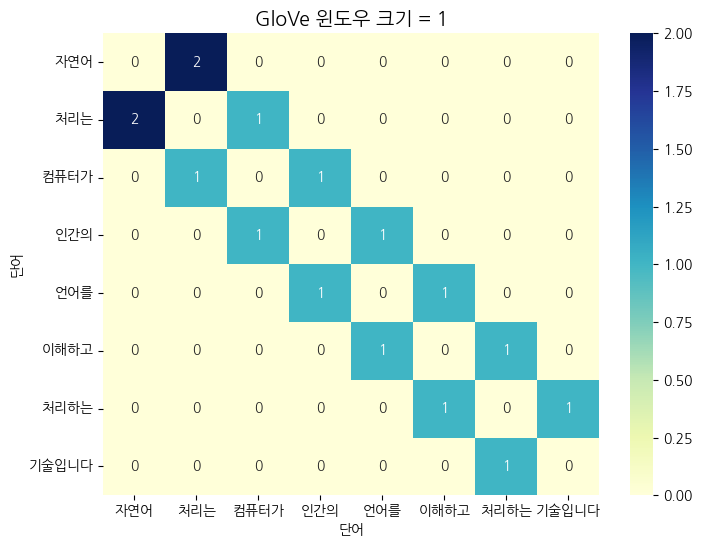



 윈도우 크기 = 3
동시출현 행렬 통계:
  총 빈도: 196.67
  0이 아닌 원소 수: 296
  최대값: 2.00
  최소값: 0.33
  평균값: 0.66


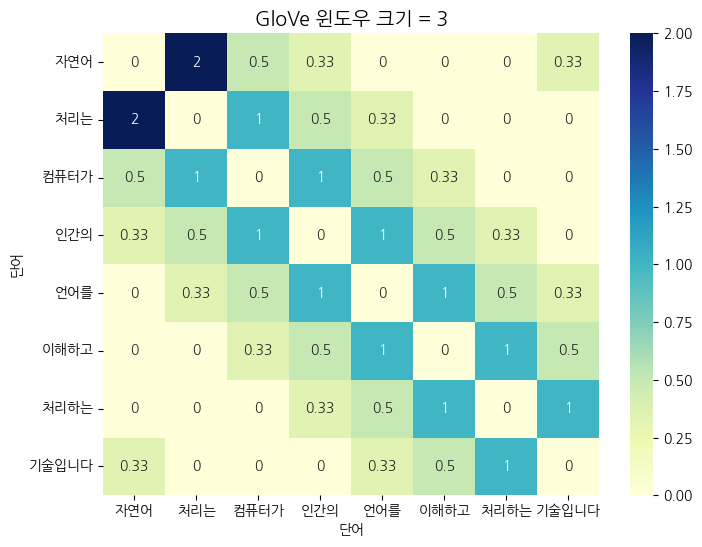



 윈도우 크기 = 5
동시출현 행렬 통계:
  총 빈도: 219.67
  0이 아닌 원소 수: 396
  최대값: 2.00
  최소값: 0.20
  평균값: 0.55


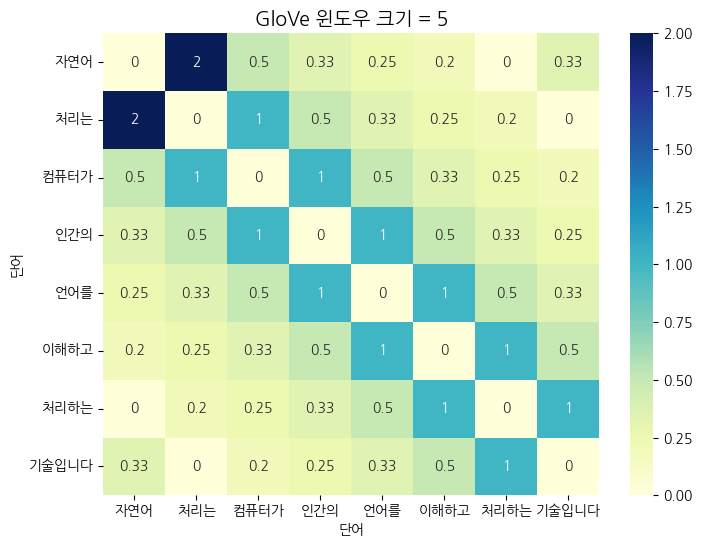

In [19]:
window_sizes = [1, 3, 5]

for w_size in window_sizes:
    print(f"\n\n 윈도우 크기 = {w_size}")
    matrix = build_cooccurrence_matrix_glove(tokenized_corpus, word_to_id, window_size=w_size)
    analyze_cooccurrence_matrix(matrix)
    visualize_heatmap(matrix, id_to_word, top_n=8, title=f"GloVe 윈도우 크기 = {w_size}")


In [20]:
results = {}
for w_size in window_sizes:
    matrix = build_cooccurrence_matrix_glove(tokenized_corpus, word_to_id, window_size=w_size)
    results[f'window_{w_size}'] = matrix

with open('problem_1_results.pkl', 'wb') as f:
    pickle.dump(results, f)
